# Machine Learning Notebook

In [1]:
import pandas as pd

In [2]:
df = pd.read_pickle('../data/df_cleaned.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   administrative           12330 non-null  int32   
 1   administrative_duration  12330 non-null  float64 
 2   informational            12330 non-null  int32   
 3   informational_duration   12330 non-null  float64 
 4   productrelated           12330 non-null  int32   
 5   productrelated_duration  12330 non-null  float64 
 6   bouncerates              12330 non-null  float64 
 7   exitrates                12330 non-null  float64 
 8   pagevalues               12330 non-null  float64 
 9   specialday               12330 non-null  float64 
 10  month                    12330 non-null  category
 11  operatingsystems         12330 non-null  category
 12  browser                  12330 non-null  category
 13  region                   12330 non-null  category
 14  traffi

**First 5 Features represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories.**

In [4]:
df.revenue.value_counts()

False    10422
True      1908
Name: revenue, dtype: int64

We note a slight class inbalance of 1:5 true vs false. 

### Data preparation for ML input
* One-Hot Encode Categorical Values
* Normlize Numeric Values
* Consider Target Class Imbalance effect on model performance. 

* Pipelines Tutorial: https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

In [5]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier

In [6]:
# encode target variable
df.revenue = df.revenue.cat.codes

In [7]:
# define input and target variables
X = df.drop(columns=['revenue'])
y = df['revenue']

# split input/target into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
# Verify shape of input and target
print(X.shape)
print(y.shape)

(12330, 17)
(12330,)


In [9]:
# create numeric pre-processing step
numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())
                                    ])
    
# create One Hot Encoder step for categorical 
categorical_transformer = Pipeline(steps=[
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])

In [10]:
df.select_dtypes(include=['category']).columns

Index(['month', 'operatingsystems', 'browser', 'region', 'traffictype',
       'visitortype', 'weekend'],
      dtype='object')

In [11]:
# select all numeric features except for target column
numeric_features = df.select_dtypes(include=['number']).drop(columns='revenue').columns

# Select all categorical features
categorical_features = df.select_dtypes(include=['category']).columns

# create pre-processor pipeline containing numeric and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
                ])

In [12]:
# instantiate model with pipeline steps
rf = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier', RandomForestClassifier())
                    ])

# Fit model with pipeline steps to training data
rf.fit(X_train, y_train);

# Make predictions
y_pred = rf.predict(X_test)

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

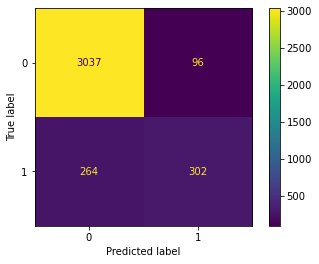

In [14]:
# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot();

In [15]:
# get classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3133
           1       0.76      0.53      0.63       566

    accuracy                           0.90      3699
   macro avg       0.84      0.75      0.79      3699
weighted avg       0.90      0.90      0.90      3699



As we can see, the imbalanced target class requires some refinement in order to hopefully improve model performance. Scoring of the dominant class, or no revenue is very good due to how many instances it contains - scoring of the minority class, revenue generator, is poor because there are so few instances of it to train the model on. 

### Class re-balance
https://machinelearningmastery.com/what-is-imbalanced-classification/  
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [16]:
# Import tool for SMOTE
from imblearn.over_sampling import SMOTE

In [17]:
print(X.shape)
print(y.shape)

(12330, 17)
(12330,)


In [18]:
X.sample(5)

,administrative,administrative_duration,informational,informational_duration,productrelated,productrelated_duration,bouncerates,exitrates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,weekend
11397,0,0.0,0,0.0,6,196.500000,0.000000,0.016667,0.0,0.0,Nov,1,1,7,2,Returning_Visitor,False
7048,3,63.4,0,0.0,10,70.933333,0.000000,0.016667,0.0,0.0,Sep,2,2,1,5,New_Visitor,False
8959,0,0.0,0,0.0,8,29.166667,0.000000,0.100000,0.0,0.0,Dec,2,2,3,2,Returning_Visitor,False
8415,4,32.0,1,43.5,311,12500.353060,0.001388,0.014687,0.0,0.0,Nov,2,2,7,2,Returning_Visitor,False
5348,0,0.0,0,0.0,24,182.416667,0.000000,0.037500,0.0,0.0,May,2,2,9,2,Returning_Visitor,True


In [19]:
y.value_counts()

0    10422
1     1908
Name: revenue, dtype: int64

note the high level of class imbalance

In [20]:
from sklearn.preprocessing import OrdinalEncoder

In [21]:
## need to encode categorical features to work with SMOTE

# Instantiate categorical encoder
enc = OrdinalEncoder()

# encode categorical features
X_post = enc.fit_transform(X)

In [34]:
#instantiate smote tool
oversample = SMOTE(random_state=1424, sampling_strategy='not majority')

# fit smote to dataset and re-sample
X_resample, y_resample = oversample.fit_resample(X_post, y)

In [30]:
# check shape of resampled features
print(X_resample.shape)
print(y_resample.shape)

(20844, 17)
(20844,)


In [35]:
# Verify target class balance change
y_resample.value_counts()

0    10422
1    10422
Name: revenue, dtype: int64

In [36]:
# split input/target into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3)

In [37]:
# instantiate model with pipeline steps
rf = RandomForestClassifier(random_state=1424)

# Fit model with pipeline steps to training data
rf.fit(X_train, y_train);

# Make predictions
y_pred = rf.predict(X_test)

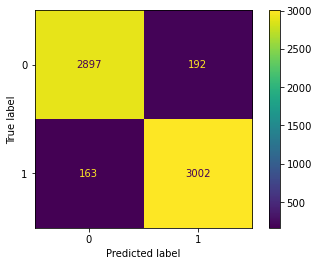

In [40]:
# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot();

In [41]:
# get classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3089
           1       0.94      0.95      0.94      3165

    accuracy                           0.94      6254
   macro avg       0.94      0.94      0.94      6254
weighted avg       0.94      0.94      0.94      6254

